In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image
from torchvision import datasets
from matplotlib.pyplot import imshow
from sklearn.metrics import f1_score

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu" 
print(device)

cpu


In [3]:
transform = transforms.Compose([ 
    transforms.Resize(size=(180, 180)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dir= "./data/train" # path to the train folder
validation_dir= "./data/validation" # path to the validation folder

train_data = datasets.ImageFolder(root=train_dir, 
                                  transform=transform) 

validation_data = datasets.ImageFolder(root=validation_dir, 
                                 transform=transform)



print(f"Train data:\n{train_data}\n\nValidation data:\n{validation_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 3689
    Root location: ./data/train
    StandardTransform
Transform: Compose(
               Resize(size=(180, 180), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

Validation data:
Dataset ImageFolder
    Number of datapoints: 989
    Root location: ./data/validation
    StandardTransform
Transform: Compose(
               Resize(size=(180, 180), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [4]:
batch_size = 4
num_workers = 2

train_set = DataLoader(dataset=train_data, 
                              batch_size=batch_size, # how many samples per batch?
                              num_workers=num_workers, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

validation_set = DataLoader(dataset=validation_data, 
                             batch_size=batch_size, 
                             num_workers=num_workers, 
                             shuffle=True) # dont usually need to shuffle testing data

train_set,validation_set

(<torch.utils.data.dataloader.DataLoader at 0x1b4b92c58b0>,
 <torch.utils.data.dataloader.DataLoader at 0x1b4b91a7230>)

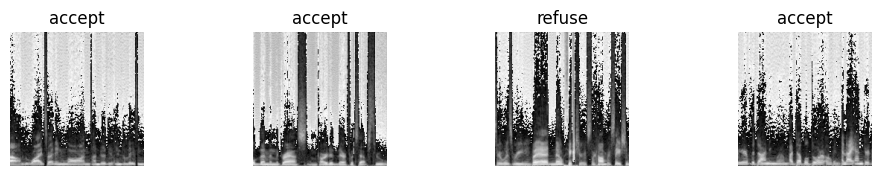

In [5]:
# I create train_data above , and I will use it here 
label_dict = {y: x for x, y in train_data.class_to_idx.items()}

# Define a function to display images
def show_images(images, labels):
    plt.figure(figsize=(12, 8))
    for i in range(len(images)):
        plt.subplot(4, 4, i + 1)
        image = to_pil_image(images[i])  # Convert tensor to PIL Image
        plt.imshow(image)
        plt.title(label_dict[labels[i].item()])  # Convert numerical label to string label
        plt.axis('off')
    plt.show()

# Get the first batch
for batch_idx, (images, labels) in enumerate(train_set):
    if batch_idx == 0:  # Only process the first batch
        show_images(images, labels)
        break

In [7]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=9):
        super(SimpleCNN, self).__init__()
        
        # image size is --> (3,180,180) 
        
        # convolutional layer with 32 filter ,input dimension is 3 because image has 3 channels
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) 
        # activation function , it adds   introduces non-linearity to the model , thus  it helps to model to learn complex functions .
        self.act1 = nn.ReLU() 
        # it reduces pixel number  (90,90)
        self.pool1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)  # --> (45,45)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2) # --> (22,22)
        
        # first flatten the channels and then feed them into the fully connected layer. Given the input shape of (128, 22, 22), flattening it results in 128 * 22 * 22.
        self.fc1 = nn.Linear(128 * 22 * 22 , 256)  
        self.act4 = nn.ReLU()
        
        # dropout drops randomly neurons , here %20 of neurons are dropped randomly . It helps to prevent overfitting
        self.dropout=nn.Dropout(p=0.2) 
        
        # The nn.Linear layer with input size 256 and output size 9 represents the output layer of our neural network. 
        # Since we have 9 classes, the output of this layer will be passed through a softmax activation function.
        # (error function  internally applies softmax activation ,you dont need to add it to here)
        # This converts the raw outputs into probabilities, representing the likelihood of each class. 
        # These probabilities are then used to calculate the error during trainin
        self.fc2 = nn.Linear(256, 9) 


    def forward(self, x):
        
        # add outputs on top of each layer and return out in the end
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = self.pool3(self.act3(self.conv3(out)))
        
        out = out.view(out.size(0), -1)
        
        out = self.act4(self.fc1(out))
        out=self.dropout(out)
        out=self.fc2(out)
        
        return out

# create model
model = SimpleCNN()

model.to(device)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=61952, out_features=256, bias=True)
  (act4): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=256, out_features=9, bias=True)
)

In [8]:
# I am going to add accuracies to these lists and I will use them outside of this function 
train_accuracies=[]
validation_accuracies=[]

# Function for training
def train(dataloader, model, loss_fn, optimizer, epoch):
    
    size = len(dataloader.dataset) # total number of images inside of loader
    num_batches = len(dataloader) # number of batches
    
    model.train()

    train_loss, correct = 0, 0
    

    for batch, (X, y) in enumerate(dataloader):
        # move X and y to GPU for faster training
        X, y = X.to(device), y.to(device) 

        # make prediction 
        pred = model(X)
        # calculate loss 
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward() # compute parameters gradients
        optimizer.step() # update parameters
        optimizer.zero_grad() #  reset the gradients of all parameters

        # Update training loss
        train_loss += loss.item() # item() method extracts the loss’s value as a Python float

        # Calculate training accuracy
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        if batch % 100 == 0:
            print(f'batch {batch} completed, train_loss={train_loss}')
    
    # loss and accuracy
    train_loss = train_loss / num_batches
    accuracy = 100 * correct / size
    
    # use this accuracy list for plotting accuracy with matplotlib
    train_accuracies.append(accuracy)

    # Print training accuracy and loss at the end of epoch
    print(f" Training Accuracy: {accuracy:.2f}%, Training Loss: {train_loss:.4f}")

def validation(dataloader, model, loss_fn, t):
    
    size = len(dataloader.dataset) # total number of images inside of loader
    num_batches = len(dataloader) # number of batches
    
    validation_loss, correct = 0, 0
    
    # sets the PyTorch model to evaluation mode, it will disable dropout layer
    model.eval()
    
    with torch.no_grad(): #  disable gradient calculation
        for X, y in dataloader:
            
            # move X and y to GPU for faster training
            X, y = X.to(device), y.to(device)
            pred = model(X) # make prediction
            validation_loss += loss_fn(pred, y).item() 
            
            # if prediction is correct add 1 to correct variable.
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    # loss and accuracy
    validation_loss /= num_batches
    accuracy = 100 * correct / size

    validation_accuracies.append(accuracy)

    # Print test accuracy and loss at the end of epoch
    print(f" Validation Accuracy: {accuracy:.2f}%, Validation Loss: {validation_loss:.4f}")

In [9]:
# Loss funciton, optimizer and epochs
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
epochs = 25

In [ ]:
# loop for training model 
for t in range(epochs):
    print(f"Epoch {t+1}")
    train(train_set, model, loss_fn, optimizer,t) 
    validation(validation_set, model, loss_fn,t)
    print("----------------------------")
print("Done!")

Epoch 1
batch 0 completed, train_loss=0.5837685465812683
batch 100 completed, train_loss=64.7058757841587
batch 200 completed, train_loss=126.60173304378986
batch 300 completed, train_loss=188.29408483207226
batch 400 completed, train_loss=251.08461153507233
batch 500 completed, train_loss=310.96708711981773
batch 600 completed, train_loss=370.7880089432001
batch 700 completed, train_loss=435.49374248087406
batch 800 completed, train_loss=494.77546387910843
batch 900 completed, train_loss=556.8564090430737
 Training Accuracy: 69.80%, Training Loss: 0.6170
 Validation Accuracy: 69.46%, Validation Loss: 0.6073
----------------------------
Epoch 2
batch 0 completed, train_loss=0.37822404503822327
batch 100 completed, train_loss=62.50362354516983
batch 200 completed, train_loss=124.11861649155617
batch 300 completed, train_loss=187.13767611980438
batch 400 completed, train_loss=248.31763558089733
batch 500 completed, train_loss=308.9253063648939
batch 600 completed, train_loss=364.90433223

In [94]:
PATH = './skynet.pth'
torch.save(model.state_dict(), PATH)

In [11]:
model = SimpleCNN()
model.load_state_dict(torch.load('./skynet.pth'))

C:\Users\Milosz\AppData\Local\Temp\ipykernel_26636\2550811230.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./skynet.pth'))


<All keys matched successfully>

## TUTAJ 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.44313723..0.9607843].


GroundTruth:  refuse refuse refuse refuse


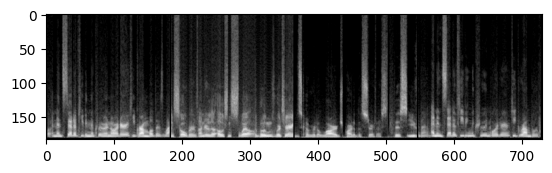

In [16]:
classes = [ 'accept', 'refuse' ]

dataiter = iter(validation_set)
images, labels = next(dataiter)

# print images
img_grid = torchvision.utils.make_grid(images).permute(1, 2, 0)

imshow(img_grid)
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [17]:
outputs = model(images)

In [18]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  refuse refuse refuse refuse


In [19]:

# Modified validation function to compute F1 score
def validation(dataloader, model, loss_fn, t):
    size = len(dataloader.dataset) # total number of images in loader
    num_batches = len(dataloader) # number of batches
    validation_loss, correct = 0, 0
    
    # Store true and predicted labels for F1 score calculation
    all_labels = []
    all_preds = []
    
    model.eval() # Set model to evaluation mode (disables dropout)
    
    with torch.no_grad(): # Disable gradient calculation
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X) # Make prediction
            validation_loss += loss_fn(pred, y).item()
            
            # Collect predictions and labels for F1
            all_labels.extend(y.cpu().numpy())
            all_preds.extend(pred.argmax(1).cpu().numpy())
            
            # Calculate accuracy
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    # Loss and accuracy
    validation_loss /= num_batches
    accuracy = 100 * correct / size
    validation_accuracies.append(accuracy)
    
    # Calculate macro-averaged F1 score
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    
    # Print validation metrics
    print(f" Validation Accuracy: {accuracy:.2f}%, Validation Loss: {validation_loss:.4f}, F1 Score (Macro): {f1_macro:.4f}")


In [20]:
print("Final evaluation on train set:")
validation(train_set, model, loss_fn, t = epochs)

Final evaluation on train set:
 Validation Accuracy: 88.91%, Validation Loss: 0.2674, F1 Score (Macro): 0.8633


In [21]:
print("Final evaluation on validation set:")
validation(validation_set, model, loss_fn, t = epochs)

Final evaluation on validation set:
 Validation Accuracy: 84.83%, Validation Loss: 0.3265, F1 Score (Macro): 0.8124
